In [1]:
# try:
#   # %tensorflow_version only exists in Colab.
#   %tensorflow_version 2.x
# except Exception:
#   pass
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import pickle
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
from image_caption_model import *

C:\Users\a0922\AppData\Roaming\Python\Python37\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\a0922\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\a0922\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)
C:\Anaconda3\envs\tf2.0rc\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Anaconda3\envs\tf2.0rc\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = n

In [2]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [3]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
top_k = 5000

# input_vocab_size = tokenizer_pt.vocab_size + 2
# target_vocab_size = tokenizer.vocab_size
target_vocab_size = top_k
dropout_rate = 0.1
transformer = Transformer(num_layers, d_model, num_heads, dff,
                           target_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [4]:
transformer.load_weights('transformer.weight')

In [5]:
def create_masks(tar):
  # Encoder padding mask
#   enc_padding_mask = create_padding_mask(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(tar)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return combined_mask, dec_padding_mask

In [6]:
with open('max_length.pickle', 'rb') as handle:
    max_length = pickle.load(handle)
max_length

49

In [7]:
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
# tokenizer.texts_to_sequences(train_captions[0])

## Caption!

* The evaluate function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [8]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [9]:
def evaluate(image):
  
  temp_input = tf.expand_dims(load_image(image)[0], 0)
  img_tensor_val = image_features_extract_model(temp_input)
  img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

 
  decoder_input = [tokenizer.word_index['<start>']]
  output = tf.expand_dims(decoder_input, 0)
    
  for i in range(max_length):
    
    combined_mask, dec_padding_mask = create_masks(output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(img_tensor_val, 
                                                 output,
                                                 False,
                                                 combined_mask,
                                                 dec_padding_mask)
#     print("predictions.shape: ", predictions.shape)
    
    
    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # return the result if the predicted_id is equal to the end token
    if int(predicted_id) == tokenizer.word_index['<end>']:
      return tf.squeeze(output, axis=0), attention_weights
    
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)
  

  return tf.squeeze(output, axis=0), attention_weights



def translate(image):
  
  result, attention_weights = evaluate(image)

  predicted_sentence = []

  for idx in result:

    predicted_sentence.append(tokenizer.index_word[int(idx)])
  sentence = ' '.join(predicted_sentence)

  print('Predicted translation: {}'.format(sentence))
  

Predicted translation: <start> a woman with a dog stands next to a dog


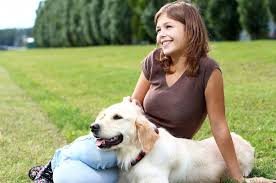

In [10]:
image_path = 'human3.jpg'

translate(image_path)

# opening the image
Image.open(image_path)